Script originally based on
https://www.kaggle.com/code/philculliton/inferring-birds-with-kaggle-models


In [1]:
import glob
import importlib
import math
import os
import pickle

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from IPython.display import Audio

tf.keras.utils.set_random_seed(42)

import preprocessing
import constants
from birddata import data
from birdmodeling import fftlayer, spectrogram_model
from birdtraining import metrics, tuning

Matplotlib is building the font cache; this may take a moment.
2023-12-15 16:18:14.687629: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 16:18:15.363469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data characteristics
- Number of classes
- Number of recordings per class
- Length of recordings
- Spectrograms for eight of the classes

In [2]:
metadata = data.Data(os.path.join(constants.base_dir, constants.metadata_csv))

2023-12-15 16:18:39.976144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-15 16:19:00.540212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-15 16:19:00.542803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

NUM_CLASSES 264


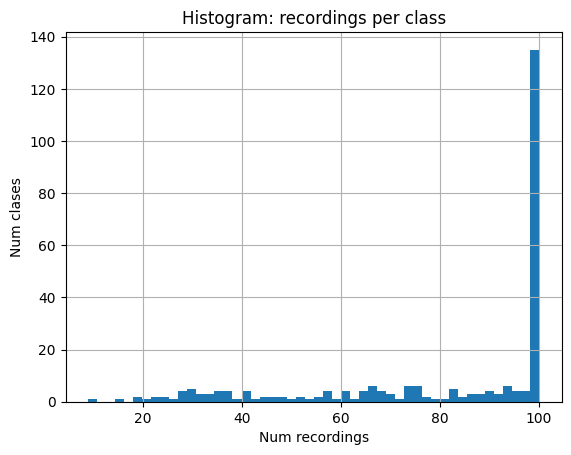

In [3]:
label_counts = metadata.df.groupby('primary_label').count()['filename']
ax = label_counts.hist(bins=50);
ax.set_title("Histogram: recordings per class")
ax.set_xlabel("Num recordings")
ax.set_ylabel("Num clases");

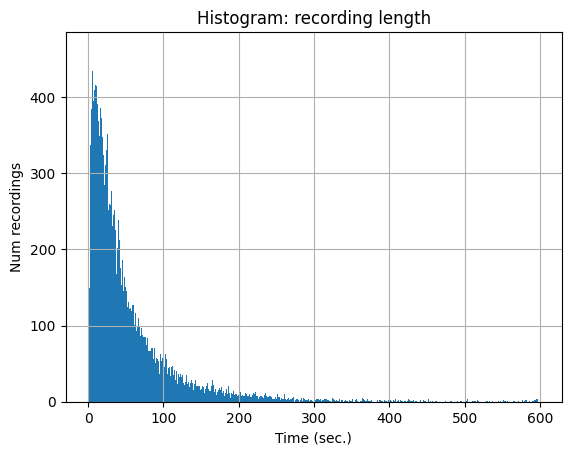

In [4]:
if 'duration' in metadata.df.columns:
    ax = metadata.df['duration'].hist(bins=range(600))
    ax.set_title("Histogram: recording length")
    ax.set_xlabel("Time (sec.)")
    ax.set_ylabel("Num recordings")

In [5]:
def display_sample_fft(df, group_id=0):
    group_size = 8
    fig, axs = plt.subplots( math.ceil(group_size/4), 4, figsize=(200,50))
    df = df[ df['duration'] >= 5.]

    for ax, (idx, row) in zip(axs.flatten(), df.groupby('primary_label').sample(n=1)[group_id*group_size:].iterrows()):
        print(row.filename)
        sample_audio, _ = preprocessing.load_audio_tensor(row.filename, row.primary_index)
        sample_fft = fftlayer.FFT()(sample_audio)
        sample_fft = sample_fft[:299, :, 0]
        ax.imshow(tf.transpose(sample_fft))
        ax.invert_yaxis()
        ax.set_title(row.primary_label, fontsize=100)

In [6]:
display_sample_fft(metadata.df)

aldfly/XC247799.ogg


2023-12-15 16:19:18.167679: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX AVX2 FMA
2023-12-15 16:20:52.078352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


ameavo/XC324505.ogg
amebit/XC298966.ogg
amecro/XC172881.ogg
amegfi/XC315598.ogg
amekes/XC56416.ogg
amepip/XC51412.ogg
amered/XC391157.ogg


# Preprocessing
- Visualize using two recordings from 'abethr1' class (African bare-eyed thrush)
  - Unmodified recordings
  - Not Shown: Chop beginning of audio
  - (Circular) shift (of first recording)
  - Combination of both recordings
  - Splitting into 5 second frames (pad/replicate, as necessary, to get 12 frames)
  - Spectrograms (of both individual recording and of combined recording)

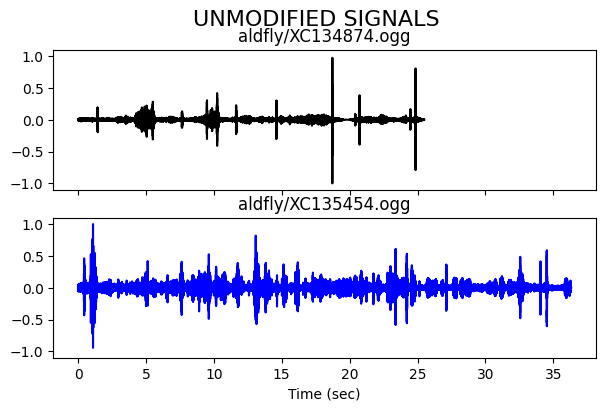

In [7]:
sample_fn0, sample_index0, sample_label0 = metadata.df[['filename', 'primary_index', 'primary_label']].loc[0].tolist()
sample_fn1, sample_index1, sample_label1 = metadata.df[['filename', 'primary_index', 'primary_label']].loc[1].tolist()
# assert sample_label0 == 'abethr1' and sample_label1 == 'abethr1'
sample_audio0, _ = preprocessing.load_audio_tensor(sample_fn0, sample_index0)
sample_audio1, _ = preprocessing.load_audio_tensor(sample_fn1, sample_index1)

fig, axs = plt.subplots(2,1, sharex=True, sharey=True, figsize=(7, 4))
fig.suptitle('UNMODIFIED SIGNALS', size=16)
axs[0].plot([x/constants.model_sr for x in range(len(sample_audio0))], sample_audio0, 'k')
axs[1].plot([x/constants.model_sr for x in range(len(sample_audio1))], sample_audio1, 'b')
axs[0].set_title(sample_fn0)
axs[1].set_title(sample_fn1)
axs[1].set_xlabel('Time (sec)');

In [8]:
Audio(sample_audio0, rate=constants.model_sr)

In [9]:
Audio(sample_audio1, rate=constants.model_sr)

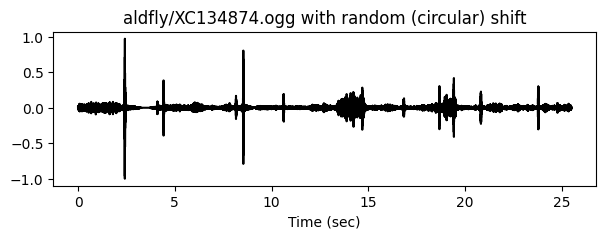

In [10]:
sample_shift0, _ = preprocessing.shift_audio(sample_audio0, sample_index1)

fig, axs = plt.subplots(1,1, figsize=(7, 2))
axs.plot([x/constants.model_sr for x in range(len(sample_shift0))], sample_shift0, 'k')
axs.set_title(f'{sample_fn0} with random (circular) shift')
axs.set_xlabel('Time (sec)');

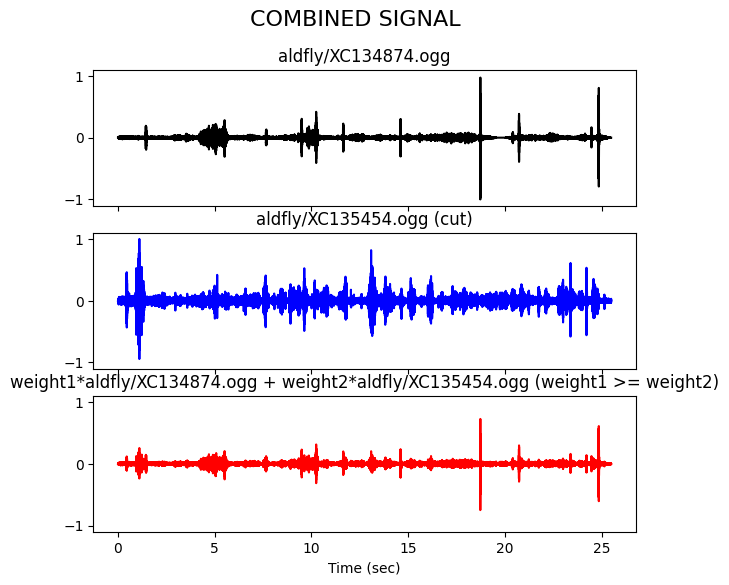

In [11]:
simple_files_for_combining = [[]] * metadata.num_classes
simple_files_for_combining[sample_index1] = [sample_fn1]
sample_audio1_cut = preprocessing.match_lengths(sample_audio0, sample_audio1)
sample_combine, _ = preprocessing.combine_recordings(sample_audio0, sample_index0, simple_files_for_combining, weight=0.75)

fig, axs = plt.subplots(3,1, figsize=(7, 6), sharex=True, sharey=True)
fig.suptitle('COMBINED SIGNAL', size=16)
axs[0].plot([x/constants.model_sr for x in range(len(sample_audio0))], sample_audio0, 'k')
axs[0].set_title(sample_fn0)
axs[1].plot([x/constants.model_sr for x in range(len(sample_audio1_cut))], sample_audio1_cut, 'b')
# for x in range(1, 3):
#     axs[1].axvline(x*len(sample_audio1)/constants.model_sr)
axs[1].set_title(sample_fn1 + ' (cut)')
axs[2].plot([x/constants.model_sr for x in range(len(sample_combine))], sample_combine, 'r')
axs[2].set_title(f'weight1*{sample_fn0} + weight2*{sample_fn1} (weight1 >= weight2)')
axs[2].set_xlabel('Time (sec)');

(6, 110250)


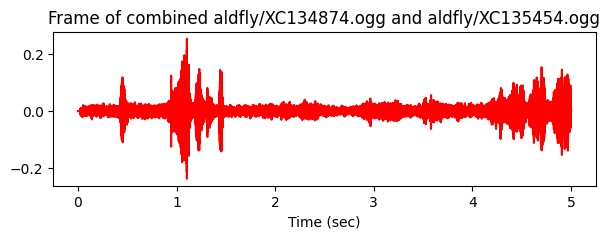

In [12]:
sample_framed, _  = preprocessing.frame_audio(sample_combine, sample_index0)
print(sample_framed.shape)
fig, axs = plt.subplots(1, 1, figsize=(7, 2), )
axs.plot([x/constants.model_sr for x in range(len(sample_framed[0]))], sample_framed[0], 'r')
axs.set_title(f'Frame of combined {sample_fn0} and {sample_fn1}')
axs.set_xlabel('Time (sec)');

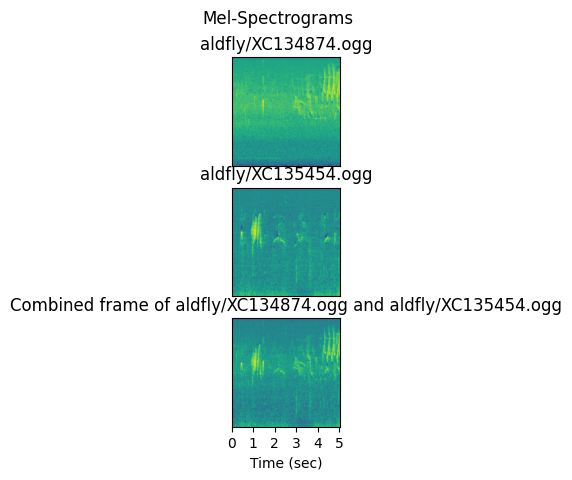

In [13]:
fft_layer = fftlayer.FFT()
sample_fft0 = fft_layer(sample_audio0)
sample_fft1 = fft_layer(sample_audio1)
sample_combined = fft_layer(sample_framed)
fig, axs = plt.subplots(3, 1)
fig.suptitle("Mel-Spectrograms")
axs[0].imshow(tf.transpose(sample_fft0[:299, :, 0]))
axs[0].set_xticks([])
axs[0].set_title(sample_fn0)
axs[1].imshow(tf.transpose(sample_fft1[:299, :, 0]))
axs[1].set_xticks([])
axs[1].set_title(sample_fn1)
axs[2].imshow(tf.transpose(sample_combined[0, :, :, 0]))
axs[2].set_title(f'Combined frame of {sample_fn0} and {sample_fn1}');
axs[2].set_xlabel('Time (sec)')
axs[2].set_xticks(ticks=range(0, sample_combined.shape[1]+1, int(1/fft_layer.stride_sec)),
               labels=range(0, 5+1))
for ax in axs:
    ax.invert_yaxis()
    # ax.set_ylabel('Frequency')
    # select_freqs = list(range(0, sample_max_freq+1, 2000))
    # select_ticks = [int(sample_combined.shape[2]*f/sample_max_freq) for f in select_freqs]
    ax.set_yticks(ticks=[], labels=[]);

# Training setup
- Preprocessing pipelines (`audio_datasets`) into single train/validation set
- Callbacks for training

In [14]:
fold_dict = metadata.get_folds()
files_for_combining = data.get_train_filenames_per_index(fold_dict['train'], metadata.competition_classes)
filename_datasets = {k: tf.data.Dataset.from_tensor_slices((fold_dict[k].filename.to_numpy(),
                                                            fold_dict[k].primary_index.to_numpy()))
                     for k in ['train', 'valid']}
audio_datasets_raw = {
    'train': filename_datasets['train'].shuffle(len(filename_datasets['train']), reshuffle_each_iteration=True)
                                       .map(preprocessing.load_audio_tensor, num_parallel_calls=tf.data.AUTOTUNE)
                                       .map(preprocessing.chop_audio, num_parallel_calls=tf.data.AUTOTUNE),
    'valid': filename_datasets['valid'].map(preprocessing.load_audio_tensor, num_parallel_calls=tf.data.AUTOTUNE)
}
audio_datasets = {
    'train': audio_datasets_raw['train']# .map(preprocessing.shift_audio)
                                        # .map(lambda x, y: preprocessing.combine_recordings(x, y, files_for_combining), num_parallel_calls=tf.data.AUTOTUNE)
                                        .map(preprocessing.frame_audio)
    ,
    'valid': audio_datasets_raw['valid'].map(preprocessing.frame_audio),
}

/mnt/efs/birdclef/birddata/data.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df = train_df[keep_rows]


In [15]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', mode='max', factor=.5, patience=3, verbose=1, min_delta=.001)
stop_early_peak = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', min_delta=0.001, patience=10, restore_best_weights=True)
stop_early_peak_4 = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', min_delta=0.001, patience=4, restore_best_weights=True)

# https://www.tensorflow.org/tutorials/keras/save_and_load
def checkpoint(modelid, save_freq):
    return tf.keras.callbacks.ModelCheckpoint(filepath='../birdclef-checkpoints/checkpoint_'+ modelid + '_{epoch:04d}.ckpt',
                                              verbose=1,
                                              save_weights_only=True,
                                              save_freq=save_freq)

# Training
- With hard-coded hyperparameters
- With tuning of hyperparmaters

In [16]:
class_weight = None# fold_dict['class_weight']
batch_size = 192

In [17]:
spec_model = spectrogram_model.setup_model(metadata.num_classes)

87910968/87910968 [==============================] - 4s 0us/step


In [18]:
audio_stats_file = "./audio_stats.pickle"
if os.path.exists(audio_stats_file):
    audio_stats = pickle.load(open(audio_stats_file, 'rb') )
else:
    adapt_ds = audio_datasets['train'].map(lambda x, _: x)
    audio_stats = spectrogram_model.get_feats_norm_stats(adapt_ds)
    pickle.dump(audio_stats, open(audio_stats_file, 'wb'))
print(audio_stats)

(-3.774538040161133, 30.16275978088379)


In [19]:
spec_best_model = tuning.build_model_hyperparameters(spectrogram_model.setup_model,
                                                     metadata.num_classes,
                                                     audio_stats,
                                                     datasets=audio_datasets,
                                                     class_weight=class_weight,
                                                     callbacks=[stop_early_peak_4],
                                                     batch_size=batch_size)

Trial 30 Complete [01h 20m 20s]
val_sparse_categorical_accuracy: 0.5297029614448547

Best val_sparse_categorical_accuracy So Far: 0.6323132514953613
Total elapsed time: 15h 15m 37s
Results summary
Results in ../birdclef-tune/spec_model/birdclef
Showing 10 best trials
Objective(name="val_sparse_categorical_accuracy", direction="max")

Trial 0016 summary
Hyperparameters:
learning_rate: 0.00021564782468849842
drop_rate: 0.05
tuner/epochs: 16
tuner/initial_epoch: 6
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.6323132514953613

Trial 0017 summary
Hyperparameters:
learning_rate: 0.00017633456769741552
drop_rate: 0.2
tuner/epochs: 16
tuner/initial_epoch: 6
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.6179118156433105

Trial 0024 summary
Hyperparameters:
learning_rate: 3.379829532081084e-05
drop_rate: 0.25
tuner/epochs: 16
tuner/initial_epoch: 6
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0019
Score: 0.5612061023712158

Trial 0025 summary
Hyperparameters:


In [20]:
initial_epoch = 0
if initial_epoch > 0:
    checkpoint_path = '../birdclef-checkpoints/checkpoint_'+ spec_model.name+"TUNE" + f'_{initial_epoch:04d}.ckpt'
    print("Loading checkpoint:", checkpoint_path)
    spec_best_model.load_weights(checkpoint_path)

In [21]:
spec_best_history = spec_best_model.fit(audio_datasets['train'].padded_batch(batch_size).prefetch(2),
                                        validation_data=audio_datasets['valid'].prefetch(2),
                                        epochs=80,
                                        callbacks=[plateau, stop_early_peak, checkpoint(spec_model.name+"TUNE", 100)],
                                        class_weight=class_weight,
                                        initial_epoch=initial_epoch)
spec_val_acc_per_epoch2 = spec_best_history.history['val_sparse_categorical_accuracy']
spec_best_epoch = spec_val_acc_per_epoch2.index(max(spec_val_acc_per_epoch2)) + 1
print('Best epoch: %d' % (spec_best_epoch,))

# spec_best_model_final = tuner.hypermodel.build(spec_best_hps)
# spec_best_model_final.fit(pre_fft_datasets[0].batch(batch_size), validation_data=pre_fft_datasets[1].batch(batch_size), epochs=best_epoch2)

Epoch 1/80
 99/100 [============================>.] - ETA: 2s - loss: 4.7045 - sparse_categorical_accuracy: 0.1068
Epoch 1: saving model to ../birdclef-checkpoints/checkpoint_spectrogram_modelTUNE_0001.ckpt
100/100 [==============================] - 326s 3s/step - loss: 4.6963 - sparse_categorical_accuracy: 0.1078 - val_loss: 5.0325 - val_sparse_categorical_accuracy: 0.1094 - lr: 2.1565e-04
Epoch 2/80
 99/100 [============================>.] - ETA: 2s - loss: 2.9401 - sparse_categorical_accuracy: 0.3773
Epoch 2: saving model to ../birdclef-checkpoints/checkpoint_spectrogram_modelTUNE_0002.ckpt
100/100 [==============================] - 299s 3s/step - loss: 2.9374 - sparse_categorical_accuracy: 0.3780 - val_loss: 3.1743 - val_sparse_categorical_accuracy: 0.2984 - lr: 2.1565e-04
Epoch 3/80
 99/100 [============================>.] - ETA: 2s - loss: 2.1110 - sparse_categorical_accuracy: 0.5426
Epoch 3: saving model to ../birdclef-checkpoints/checkpoint_spectrogram_modelTUNE_0003.ckpt
100/1

In [22]:
spec_model_filename = f'../birdclef-checkpoints/{spec_model.name}_TUNE'

In [23]:
spec_best_model.save_weights(spec_model_filename)